# Spatial Transcriptomics Data

In [1]:
import scanpy as sc

adata = sc.read_h5ad("../data/output-dgi-10-10-20MAY2025.h5ad")
adata.layers["counts"] = adata.layers["counts"].todense()
adata = adata[adata.obs["folder"].eq("05-27")]

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: Layer 'counts' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


# Data

In [2]:
from tqdm import tqdm 

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.utils import k_hop_subgraph
import numpy as np
from scipy.spatial import cKDTree

class GraphDatasetGenerator:
    def __init__(self, adata, k=1):
        self.adata = adata
        self.k = k
        self.edge_index = self.create_edge_index()
        self.node_features = torch.tensor(adata.X).float()
        self.counts = torch.tensor(adata.layers["counts"]).float()
        self.batch = torch.tensor(adata.obs["folder"].cat.codes).long()
        self.metadata = {
            "plin2": torch.tensor(adata.obs["plin2_area"]).float(),
            "oro": torch.tensor(adata.obs["oil_red_o_area"]).float(),
            "lipid_droplet": torch.tensor(adata.obs["lipid_droplet_area"]).float(),
            "distance_to_nearest_amyloid": torch.tensor(adata.obs["distance_to_nearest_amyloid"]).float(),
        }

    def create_edge_index(self):
        coords = self.adata.obs[['x_centroid', 'y_centroid']].values
        tree = cKDTree(coords)
        _, neighbors = tree.query(coords, k=31)
        rows = np.repeat(np.arange(len(coords)), 30)
        cols = neighbors[:, 1:].reshape(-1)
        return torch.tensor([rows, cols], dtype=torch.long)

    def generate_subgraphs(self):
        subgraphs = []
        num_nodes = self.node_features.size(0)

        for center_node in tqdm(range(num_nodes)):
            subset, edge_index, mapping, _ = k_hop_subgraph(
                center_node, self.k, self.edge_index, relabel_nodes=True
            )

            # Build subgraph data
            data = Data(
                x=self.node_features[subset],
                counts=self.counts[subset],
                batch=self.batch[subset],
                edge_index=edge_index,
                center_idx=mapping,  # index of center node in subgraph
            )

            for key, tensor in self.metadata.items():
                data[key] = tensor[subset]

            subgraphs.append(data)

        return subgraphs

class SubgraphDataset(InMemoryDataset):
    def __init__(self, adata, transform=None):
        self.generator = GraphDatasetGenerator(adata)
        self.subgraphs = self.generator.generate_subgraphs()
        super().__init__(None, transform)

    def len(self):
        return len(self.subgraphs)

    def get(self, idx):
        return self.subgraphs[idx]


In [3]:
dataset = SubgraphDataset(adata)

# Example
sample = dataset[0]
print(sample)
print("Center node index:", sample.center_idx.item())

/tmp/ipykernel_3350433/1968146773.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor([rows, cols], dtype=torch.long)
/tmp/ipykernel_3350433/1968146773.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.batch = torch.tensor(adata.obs["folder"].cat.codes).long()
/tmp/ipykernel_3350433/1968146773.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "plin2": torch.tensor(adata

Data(x=[11, 366], edge_index=[2, 70], counts=[11, 366], batch=[11], center_idx=[1], plin2=[11], oro=[11], lipid_droplet=[11], distance_to_nearest_amyloid=[11])
Center node index: 0


In [4]:
sample

Data(x=[11, 366], edge_index=[2, 70], counts=[11, 366], batch=[11], center_idx=[1], plin2=[11], oro=[11], lipid_droplet=[11], distance_to_nearest_amyloid=[11])

# Encoding Layers

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

# === Expression + Pathology Node Encoder ===
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class NodeEncodingLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.expression_encoder = Encoder(input_dim)

        def mlp():
            return nn.Sequential(
                nn.Linear(1, 64),
                nn.ReLU(),
                nn.Linear(64, 8)
            )

        self.pathology_head = nn.ModuleDict({
            "oil_red_o": mlp(),
            "plin2": mlp(),
            "lipid_droplet": mlp(),
            "distance_to_amyloid": mlp()
        })

        self.project = nn.Linear(8*4 + 64, output_dim)

    def forward(self, data):
        expression = self.expression_encoder(data.x)
        pathology = torch.cat([
            self.pathology_head["oil_red_o"](data.oro.unsqueeze(1)),
            self.pathology_head["plin2"](data.plin2.unsqueeze(1)),
            self.pathology_head["lipid_droplet"](data.lipid_droplet.unsqueeze(1)),
            self.pathology_head["distance_to_amyloid"](data.distance_to_nearest_amyloid.unsqueeze(1)),
        ], dim=1)
        return self.project(torch.cat([expression, pathology], dim=1))  # [N, D]

# === Edge Encoder ===
class EdgeEncodingLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, node_embeddings, edge_index):
        src = node_embeddings[edge_index[0]]
        tgt = node_embeddings[edge_index[1]]
        edge_input = torch.cat([src, tgt], dim=1)
        return self.edge_mlp(edge_input)

# === Type Embedding Layer ===
class TokenTypeEmbedding(nn.Module):
    def __init__(self, num_types: int, dim: int):
        super().__init__()
        self.type_embedding = nn.Embedding(num_types, dim)

    def forward(self, token_embeddings: torch.Tensor, type_ids: torch.Tensor):
        return token_embeddings + self.type_embedding(type_ids)

# === Full Graph Tokenizer ===
class GraphTokenizer(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.node_encoder = NodeEncodingLayer(input_dim, hidden_dim)
        self.edge_encoder = EdgeEncodingLayer(hidden_dim)
        self.token_type_embedder = TokenTypeEmbedding(num_types=3, dim=hidden_dim)
        self.graph_token = nn.Parameter(torch.randn(1, hidden_dim))  # learnable [CLS] token

    def forward(self, data):
        # Node tokens
        device = data.x.device
        node_tokens = self.node_encoder(data)  # [N, D]
        node_type_ids = torch.zeros(node_tokens.size(0), dtype=torch.long, device=device)

        # Edge tokens
        edge_tokens = self.edge_encoder(node_tokens, data.edge_index)  # [E, D]
        edge_type_ids = torch.ones(edge_tokens.size(0), dtype=torch.long, device=device)

        # Graph token
        graph_token = self.graph_token.expand(1, -1)  # [1, D]
        graph_type_id = torch.tensor([2], dtype=torch.long, device=node_tokens.device)

        # Combine tokens and types
        tokens = torch.cat([node_tokens, edge_tokens, graph_token], dim=0)  # [T, D]
        type_ids = torch.cat([node_type_ids, edge_type_ids, graph_type_id], dim=0)  # [T]

        # Add type embeddings
        tokens = self.token_type_embedder(tokens.unsqueeze(0), type_ids.unsqueeze(0))  # [1, T, D]

        # Index of center node token (in concatenated tokens, node tokens first)
        center_token_idx = int(data.center_idx)

        return tokens.squeeze(0), type_ids, center_token_idx

In [6]:
tokenizer = GraphTokenizer(input_dim=sample.x.shape[1], hidden_dim=256)
tokens, type_ids, center_token_idx = tokenizer(dataset[4])

print(tokens.shape)    # [T, 256]
print(type_ids.shape)  # [T]
print(center_token_idx)

torch.Size([828, 256])
torch.Size([828])
4


# Transformer Layers

In [7]:
class TransformerStack(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, src_key_padding_mask=None):
        # x: [T, B, D] for nn.Transformer modules (T=seq len, B=batch, D=features)
        # but we have [B, T, D] or [T, D], so be careful to transpose if needed
        if x.dim() == 3:
            x = x.transpose(0, 1)  # to [T, B, D]

        out = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

        return out.transpose(0, 1)  # back to [B, T, D] or squeeze batch if needed


In [8]:
tokens, type_ids, center_idx = tokenizer(sample)
tokens = tokens.unsqueeze(1)  # [T, 1, D]

transformer_stack = TransformerStack(d_model=tokens.size(-1), num_heads=8, num_layers=6)
encoded = transformer_stack(tokens)  # [T, 1, D]

encoded = encoded.squeeze(1)  # [T, D]
center_embedding = encoded[center_idx]
cls_embedding = encoded[-1]  # the last token = CLS token

print("Center node embedding:", center_embedding.shape)
print("Graph CLS embedding:", cls_embedding.shape)


Center node embedding: torch.Size([256])
Graph CLS embedding: torch.Size([256])


/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Output

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial, Normal, Bernoulli

class MultiTaskOutputHead(nn.Module):
    def __init__(self, embedding_dim, num_counts=366):
        super().__init__()
        # Counts NB mean logits per feature
        self.nb_mean_logits = nn.Linear(embedding_dim, num_counts)  # [D -> num_counts]

        # Shared dispersion (scalar, learnable positive parameter via softplus)
        self.log_dispersion = nn.Parameter(torch.zeros(num_counts))  # one per feature


        # Hurdle Normal heads for plin2, oro, lipid_droplet (log1p inputs)
        # Each outputs: mixture logits (zero/nonzero), mean, and log std dev
        def hurdle_net():
            return nn.Sequential(
                nn.Linear(embedding_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 3)  # logits for zero/nonzero, mean, log_std
            )

        self.hurdle_plin2 = hurdle_net()
        self.hurdle_oro = hurdle_net()
        self.hurdle_lipid = hurdle_net()

        # Amyloid soft-binarization parameters:
        # alpha controls sharpness of sigmoid cutoff at 60
        self.threshold = 60.0

        # Amyloid prediction head outputs predicted distance
        self.amyloid_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # predicted distance scalar
        )

    def forward(self, embedding):
        """
        embedding: [batch_size, embedding_dim]
        Returns dict of params for losses
        """

        out = {}

        # Counts NB mean logits
        out["nb_logits"] = self.nb_mean_logits(embedding)  # [B, num_counts]

        # Dispersion param (positive)
        out["dispersion"] = F.softplus(self.log_dispersion) + 1e-6  # [num_counts]


        # Hurdle normal params
        def hurdle_params(net, emb):
            params = net(emb)  # [B, 3]
            logits = params[:, 0]         # zero vs nonzero logit
            mean = params[:, 1]           # mean of normal
            log_std = params[:, 2].clamp(-10, 2)  # stability clamp
            std = torch.exp(log_std)
            return logits, mean, std

        out["plin2_logits"], out["plin2_mean"], out["plin2_std"] = hurdle_params(self.hurdle_plin2, embedding)
        out["oro_logits"], out["oro_mean"], out["oro_std"] = hurdle_params(self.hurdle_oro, embedding)
        out["lipid_logits"], out["lipid_mean"], out["lipid_std"] = hurdle_params(self.hurdle_lipid, embedding)

        # Amyloid distance prediction (continuous)
        out["amyloid_dist_pred"] = self.amyloid_head(embedding).squeeze(-1)  # [B]

        return out

mtoh = MultiTaskOutputHead(256)

In [10]:
mtoh(center_embedding.unsqueeze(0))

{'nb_logits': tensor([[ 3.8894e-01,  8.4673e-01,  9.2688e-01,  4.8604e-01,  2.4710e-02,
           9.0532e-01, -2.3946e-01, -5.6907e-01, -3.9096e-01, -3.2073e-01,
          -1.0078e+00, -1.2857e+00,  3.6164e-01, -1.7059e-01, -7.7310e-01,
          -2.4536e-01, -9.2938e-01, -2.3486e-01,  6.0705e-02, -1.2628e-02,
           2.7387e-01,  3.1029e-01, -2.0362e-01, -3.9242e-01,  3.0212e-01,
           1.6029e-01, -1.0485e+00, -1.1430e-03,  1.5041e-01,  2.9141e-01,
           1.8965e-01, -8.2576e-01,  4.1893e-02,  6.2806e-01,  1.3603e-02,
           4.5749e-01, -4.3590e-01, -3.2534e-02, -1.1441e-01,  2.0769e-01,
           4.8403e-01,  6.9828e-01, -5.6140e-02, -4.1127e-01,  1.4967e-01,
          -1.3090e-01,  6.8359e-02, -7.5985e-01, -1.8405e-01,  5.4895e-01,
          -1.0699e+00, -8.7738e-01,  1.0108e+00,  1.8236e-01,  4.9367e-01,
           8.0438e-01, -1.5843e-01, -7.4442e-01, -5.7814e-01, -4.4865e-01,
           6.2816e-01,  7.5208e-01, -7.3610e-01,  8.4456e-01,  2.5592e-01,
           2

# Loss

In [11]:
class DGIDiscriminator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, global_emb, node_embs):
        # global_emb: [D]
        # node_embs: [N, D]
        global_proj = self.linear(global_emb)   # [D]
        scores = torch.matmul(node_embs, global_proj)  # [N]
        return scores  # raw scores for BCEWithLogitsLoss
    
def dgi_loss(discriminator, cls_emb, node_embs, corrupted_cls_emb, corrupted_node_embs):
    pos_scores = discriminator(cls_emb, node_embs)             # label=1
    neg_scores = discriminator(corrupted_cls_emb, corrupted_node_embs)  # label=0
    
    labels_pos = torch.ones_like(pos_scores)
    labels_neg = torch.zeros_like(neg_scores)
    
    loss_pos = nn.BCEWithLogitsLoss()(pos_scores, labels_pos)
    loss_neg = nn.BCEWithLogitsLoss()(neg_scores, labels_neg)
    
    return loss_pos + loss_neg



In [12]:
def nb_loss(logits, dispersion, counts):
    # logits: [B, F]
    # dispersion: [F] or [B, F]
    # counts: [B, F]

    # If dispersion is [F], expand to [B, F]
    if dispersion.dim() == 1:
        dispersion = dispersion.unsqueeze(0).expand_as(logits)

    nb = NegativeBinomial(total_count=dispersion, logits=logits)
    return -nb.log_prob(counts).sum()



In [13]:
def hurdle_normal_loss(logits, mean, std, target):
    # target: raw values (positive or zero)
    # We model log1p(target)
    x = torch.log1p(target)

    p_zero = torch.sigmoid(-logits)  # probability of zero

    zero_mask = (target == 0).float()
    nonzero_mask = 1 - zero_mask

    normal_dist = Normal(mean, std)

    # Log prob for zero
    log_prob_zero = torch.log(p_zero + 1e-8)

    # Log prob for nonzero
    log_prob_nonzero = torch.log(1 - p_zero + 1e-8) + normal_dist.log_prob(x)

    loss = -(
        zero_mask * log_prob_zero +
        nonzero_mask * log_prob_nonzero
    )

    return loss.sum()


In [14]:
def amyloid_soft_binarization_loss(dist_pred, dist_true, alpha, threshold=60.0):
    # dist_true, dist_pred: [B] floats
    # alpha: scalar > 0

    y = torch.sigmoid(-alpha * (dist_true - threshold))
    y_pred = torch.sigmoid(-alpha * (dist_pred - threshold))

    bce = F.binary_cross_entropy(y_pred, y)
    return bce

def amyloid_bce_loss(dist_pred, dist_true, threshold=60.0):
    # Binarize the true distances at the threshold
    y = (dist_true < threshold).float()  # 1 if dist < 60, else 0
    
    # Apply sigmoid to predicted logits
    y_pred = torch.sigmoid(dist_pred)
    
    # Compute BCE loss
    bce = nn.functional.binary_cross_entropy(y_pred, y)
    return bce


In [15]:
def total_loss(outputs, batch):
    """
    outputs: dict from MultiTaskOutputHead.forward()
    batch: data object with ground truth fields:
        counts, plin2, oro, lipid_droplet, distance_to_nearest_amyloid
    """

    loss = 0.0

    # NB counts loss
    loss += nb_loss(outputs["nb_logits"], outputs["dispersion"], batch["counts"])

    # Hurdle normal losses (log1p inputs)
    loss += hurdle_normal_loss(outputs["plin2_logits"], outputs["plin2_mean"], outputs["plin2_std"], batch["plin2"])
    loss += hurdle_normal_loss(outputs["oro_logits"], outputs["oro_mean"], outputs["oro_std"], batch["oro"])
    loss += hurdle_normal_loss(outputs["lipid_logits"], outputs["lipid_mean"], outputs["lipid_std"], batch["lipid_droplet"])

    # Amyloid soft binarization loss
    loss += amyloid_bce_loss(outputs["amyloid_dist_pred"], batch["distance_to_nearest_amyloid"])

    return loss

def total_loss(outputs, batch):
    """
    outputs: dict from MultiTaskOutputHead.forward()
    batch: data object with ground truth fields:
        counts, plin2, oro, lipid_droplet, distance_to_nearest_amyloid
    Returns:
        dict with keys: 'total', 'counts', 'plin2', 'oro', 'lipid_droplet', 'amyloid'
    """

    losses = {}

    # NB counts loss
    counts_loss = nb_loss(outputs["nb_logits"], outputs["dispersion"], batch["counts"])
    losses['counts'] = counts_loss

    # Hurdle normal losses (log1p inputs)
    plin2_loss = hurdle_normal_loss(outputs["plin2_logits"], outputs["plin2_mean"], outputs["plin2_std"], batch["plin2"])
    losses['plin2'] = plin2_loss

    oro_loss = hurdle_normal_loss(outputs["oro_logits"], outputs["oro_mean"], outputs["oro_std"], batch["oro"])
    losses['oro'] = oro_loss

    lipid_loss = hurdle_normal_loss(outputs["lipid_logits"], outputs["lipid_mean"], outputs["lipid_std"], batch["lipid_droplet"])
    losses['lipid_droplet'] = lipid_loss

    # Amyloid binary cross-entropy loss
    amyloid_loss = amyloid_bce_loss(outputs["amyloid_dist_pred"], batch["distance_to_nearest_amyloid"])
    losses['amyloid'] = amyloid_loss

    # Total loss is sum of all
    losses['total'] = sum(losses.values())

    return losses

def total_loss(outputs, batch, cls_emb, node_embs, corrupted_cls_emb, corrupted_node_embs, discriminator, dgi_weight=1.0):
    """
    outputs: dict from MultiTaskOutputHead.forward()
    batch: ground truth dict
    cls_emb: [D] tensor, original graph summary ([CLS] token)
    node_embs: [N, D] tensor, original node embeddings (all tokens except [CLS])
    corrupted_cls_emb: [D] tensor, corrupted graph summary
    corrupted_node_embs: [N, D] tensor, corrupted node embeddings
    discriminator: DGIDiscriminator instance
    dgi_weight: float, weighting factor for DGI loss
    """

    losses = {}

    # Supervised losses (same as before)
    counts_loss = nb_loss(outputs["nb_logits"], outputs["dispersion"], batch["counts"])
    plin2_loss = hurdle_normal_loss(outputs["plin2_logits"], outputs["plin2_mean"], outputs["plin2_std"], batch["plin2"])
    oro_loss = hurdle_normal_loss(outputs["oro_logits"], outputs["oro_mean"], outputs["oro_std"], batch["oro"])
    lipid_loss = hurdle_normal_loss(outputs["lipid_logits"], outputs["lipid_mean"], outputs["lipid_std"], batch["lipid_droplet"])
    amyloid_loss = amyloid_bce_loss(outputs["amyloid_dist_pred"], batch["distance_to_nearest_amyloid"])

    losses.update({
        'counts': counts_loss,
        'plin2': plin2_loss,
        'oro': oro_loss,
        'lipid_droplet': lipid_loss,
        'amyloid': amyloid_loss,
    })

    # DGI loss
    dgi_loss_val = dgi_loss(discriminator, cls_emb, node_embs, corrupted_cls_emb, corrupted_node_embs)
    losses['dgi'] = dgi_loss_val

    # Total loss = supervised + weighted DGI
    losses['total'] = sum([v for k, v in losses.items() if k != 'total']) + dgi_weight * dgi_loss_val

    return losses


In [16]:
import copy
import torch

def corrupt_batch(batch):
    corrupted = copy.deepcopy(batch)  # clone so you don't overwrite original batch

    # Shuffle node features along node dimension
    perm = torch.randperm(corrupted.x.size(0))
    corrupted.x = corrupted.x[perm]

    # If you have other node attributes used by tokenizer, shuffle those similarly:
    for attr_name in ['plin2', 'oro', 'lipid_droplet', 'distance_to_nearest_amyloid', 'counts']:
        if hasattr(corrupted, attr_name):
            attr = getattr(corrupted, attr_name)
            if isinstance(attr, torch.Tensor) and attr.size(0) == corrupted.x.size(0):
                setattr(corrupted, attr_name, attr[perm])

    return corrupted


In [17]:
# Assume batch is the full subgraph data object

tokens, type_ids, center_idx = tokenizer(sample)
encoded_tokens = transformer_stack(tokens.unsqueeze(1))  # [T, 1, D]
encoded_tokens = encoded_tokens.squeeze(1)        # [T, D]

center_embedding = encoded_tokens[center_idx]     # [D]
outputs = mtoh(center_embedding.unsqueeze(0))  # [1, D]

# Extract ground truth for the center node:
center_counts = sample.counts[center_idx].unsqueeze(0)  # [1, num_counts]
center_plin2 = sample.plin2[center_idx].unsqueeze(0)    # [1]
center_oro = sample.oro[center_idx].unsqueeze(0)        # [1]
center_lipid = sample.lipid_droplet[center_idx].unsqueeze(0)  # [1]
center_amyloid = sample.distance_to_nearest_amyloid[center_idx].unsqueeze(0)  # [1]

# Make a mini "center" batch dict for losses
center_batch = {
    "counts": center_counts,
    "plin2": center_plin2,
    "oro": center_oro,
    "lipid_droplet": center_lipid,
    "distance_to_nearest_amyloid": center_amyloid
}

cls_emb = encoded_tokens[-1]           # [D], the [CLS] token
node_embs = encoded_tokens[:-1]        # [N, D], all other tokens

# Create corrupted input, run through tokenizer + transformer to get corrupted embeddings
corrupted_batch = corrupt_batch(batch)  # You define this (e.g., shuffle node features)
corrupted_tokens, _, _ = tokenizer(corrupted_batch)
corrupted_tokens = corrupted_tokens.unsqueeze(1)
corrupted_encoded = transformer(corrupted_tokens).squeeze(1)
corrupted_cls_emb = corrupted_encoded[-1]
corrupted_node_embs = corrupted_encoded[:-1]

outputs = output_head(cls_emb.unsqueeze(0))
losses = total_loss(outputs, center_batch, cls_emb, node_embs, corrupted_cls_emb, corrupted_node_embs, discriminator, dgi_weight=1.0)

loss = losses['total']

NameError: name 'batch' is not defined

# Everything 

In [17]:
import os
import wandb
import torch
import torch.nn as nn
import torch.optim as optim  # ← this is the missing line
from collections import deque
from torch_geometric.data import DataLoader

# Initialize wandb project
wandb.init(project="TokenGT-training", name="kanna-chameleon", config={
    "lr": 1e-3,
    "batch_size": 1,
    "epochs": 1,
})

rolling_window_size = 100
rolling_losses = deque(maxlen=rolling_window_size)
rolling_component_losses = {
    "counts": deque(maxlen=rolling_window_size),
    "plin2": deque(maxlen=rolling_window_size),
    "oro": deque(maxlen=rolling_window_size),
    "lipid_droplet": deque(maxlen=rolling_window_size),
    "amyloid": deque(maxlen=rolling_window_size),
    "dgi": deque(maxlen=rolling_window_size),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = DGIDiscriminator(256).to(device)

# Model components
tokenizer = GraphTokenizer(input_dim=sample.x.shape[1], hidden_dim=256).to(device)
transformer = TransformerStack(d_model=256, num_heads=8, num_layers=4).to(device)
output_head = MultiTaskOutputHead(embedding_dim=256, num_counts=366).to(device)

# Optimizer
params = list(tokenizer.parameters()) + list(transformer.parameters()) + list(output_head.parameters()) + list(discriminator.parameters())
optimizer = optim.Adam(params, lr=1e-5)

# Data loader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Directory for checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(wandb.config.epochs):
    total = 0.0
    total_component_loss = {k: 0.0 for k in rolling_component_losses.keys()}

    tokenizer.train()
    transformer.train()
    output_head.train()
    discriminator.train()

    batch_num = 0
    for batch in tqdm(loader):
        batch_num += 1
        batch = batch.to(device)

        tokens, type_ids, center_idx = tokenizer(batch)
        tokens = tokens.unsqueeze(1)
        encoded_tokens = transformer(tokens).squeeze(1)

        center_embedding = encoded_tokens[center_idx]
        outputs = output_head(center_embedding.unsqueeze(0))

        center_counts = batch.counts[center_idx].unsqueeze(0).to(device)
        center_plin2 = batch.plin2[center_idx].unsqueeze(0).to(device)
        center_oro = batch.oro[center_idx].unsqueeze(0).to(device)
        center_lipid = batch.lipid_droplet[center_idx].unsqueeze(0).to(device)
        center_amyloid = batch.distance_to_nearest_amyloid[center_idx].unsqueeze(0).to(device)

        center_batch = {
            "counts": center_counts,
            "plin2": center_plin2,
            "oro": center_oro,
            "lipid_droplet": center_lipid,
            "distance_to_nearest_amyloid": center_amyloid
        }

        cls_emb = encoded_tokens[-1]           # [D], the [CLS] token
        node_embs = encoded_tokens[:-1]        # [N, D], all other tokens

        corrupted_batch = corrupt_batch(batch).to(device)
        corrupted_tokens, _, _ = tokenizer(corrupted_batch)
        corrupted_tokens = corrupted_tokens.unsqueeze(1)
        corrupted_encoded = transformer(corrupted_tokens).squeeze(1)
        corrupted_cls_emb = corrupted_encoded[-1]
        corrupted_node_embs = corrupted_encoded[:-1]

        outputs = output_head(cls_emb.unsqueeze(0))
        loss_dict = total_loss(outputs, center_batch, cls_emb, node_embs, corrupted_cls_emb, corrupted_node_embs, discriminator, dgi_weight=1.0)
        loss = loss_dict['total']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
        for k in rolling_component_losses.keys():
            total_component_loss[k] += loss_dict.get(k, 0).item()

        rolling_losses.append(loss.item())
        for k in rolling_component_losses.keys():
            rolling_component_losses[k].append(loss_dict.get(k, 0).item())

        if batch_num % 10 == 0:
            wandb.log({
                "rolling_loss": sum(rolling_losses) / len(rolling_losses),
                **{f"rolling_{k}_loss": sum(v) / len(v) for k, v in rolling_component_losses.items()},
                "batch": batch_num,
                "epoch": epoch + 1
            })

    # Log epoch average losses
    epoch_loss = total / len(loader)
    wandb.log({
        "epoch_loss": epoch_loss,
        **{f"epoch_{k}_loss": total_component_loss[k] / len(loader) for k in rolling_component_losses},
        "epoch": epoch + 1,
    })

    print(f"Epoch {epoch+1} | Average Loss: {epoch_loss:.4f}")

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    torch.save({
        "epoch": epoch + 1,
        "tokenizer_state_dict": tokenizer.state_dict(),
        "transformer_state_dict": transformer.state_dict(),
        "output_head_state_dict": output_head.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": epoch_loss,
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")


wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 69552/69552 [13:43<00:00, 84.42it/s]

Epoch 1 | Average Loss: 224.0124
Saved checkpoint: checkpoints/model_epoch_1.pt


In [ ]:
checkpoint = torch.load(checkpoint_path)
tokenizer.load_state_dict(checkpoint["tokenizer_state_dict"])
transformer.load_state_dict(checkpoint["transformer_state_dict"])
output_head.load_state_dict(checkpoint["output_head_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [18]:
import os
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.data import DataLoader

# Paths
checkpoint_dir = "checkpoints"
output_dir = "embeddings"
os.makedirs(output_dir, exist_ok=True)

# Choose which checkpoint to use
checkpoint_path = os.path.join(checkpoint_dir, "model_epoch_1.pt")

# Load model components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = GraphTokenizer(input_dim=sample.x.shape[1], hidden_dim=256).to(device)
transformer = TransformerStack(d_model=256, num_heads=8, num_layers=4).to(device)

# Load saved weights
checkpoint = torch.load(checkpoint_path, map_location=device)
tokenizer.load_state_dict(checkpoint["tokenizer_state_dict"])
transformer.load_state_dict(checkpoint["transformer_state_dict"])

tokenizer.eval()
transformer.eval()

# Set up data loader
loader = DataLoader(dataset, batch_size=1, shuffle=False)

cls_embeddings = []
center_embeddings = []

with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(device)
        
        tokens, _, center_idx = tokenizer(batch)
        tokens = tokens.unsqueeze(1)  # Add sequence dimension
        encoded = transformer(tokens).squeeze(1)  # Remove sequence dimension

        cls_emb = encoded[-1].detach().cpu().numpy()             # [D]
        center_emb = encoded[center_idx].detach().cpu().numpy()  # [D]

        cls_embeddings.append(cls_emb)
        center_embeddings.append(center_emb)

# Convert to arrays and save
cls_embeddings = np.stack(cls_embeddings)
center_embeddings = np.stack(center_embeddings)

np.save(os.path.join(output_dir, "cls_embeddings.npy"), cls_embeddings)
np.save(os.path.join(output_dir, "center_embeddings.npy"), center_embeddings)

print("Saved embeddings:")
print(f" - [CLS]:   {cls_embeddings.shape}")
print(f" - [Center]: {center_embeddings.shape}")


100%|██████████| 69552/69552 [01:58<00:00, 589.22it/s]


Saved embeddings:
 - [CLS]:   (69552, 256)
 - [Center]: (69552, 256)


In [21]:
adata.obsm["X_cls"] = cls_embeddings
adata.obsm["X_node"] = center_embeddings

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79f2385c9cd0, raw_cell="adata.obsm["X_cls"] = cls_embeddings
adata.obsm["X.." transformed_cell="adata.obsm["X_cls"] = cls_embeddings
adata.obsm["X.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y143sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for post_run_cell), with arguments args (<ExecutionResult object at 79f2385c9c50, execution_count=21 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79f2385c9cd0, raw_cell="adata.obsm["X_cls"] = cls_embeddings
adata.obsm["X.." transformed_cell="adata.obsm["X_cls"] = cls_embeddings
adata.obsm["X.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y143sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79f2bbcd9550, raw_cell="sc.pp.neighbors(adata, use_rep="X_cls")
sc.tl.leid.." transformed_cell="sc.pp.neighbors(adata, use_rep="X_cls")
sc.tl.leid.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y144sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3350433/1593809682.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="spatial_clusters")


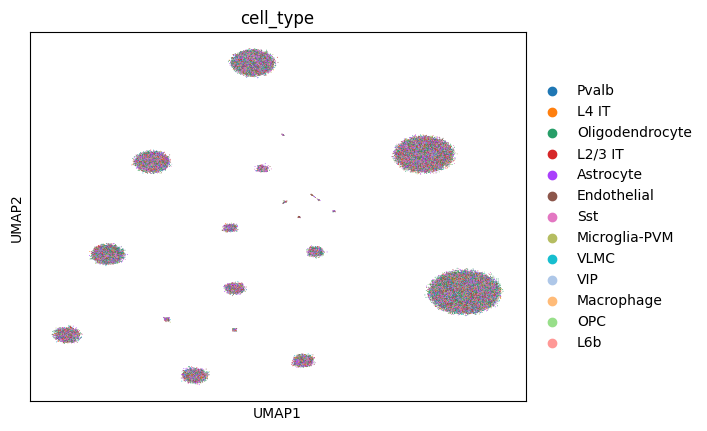

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for post_run_cell), with arguments args (<ExecutionResult object at 79f232272f20, execution_count=22 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79f2bbcd9550, raw_cell="sc.pp.neighbors(adata, use_rep="X_cls")
sc.tl.leid.." transformed_cell="sc.pp.neighbors(adata, use_rep="X_cls")
sc.tl.leid.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y144sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [22]:
sc.pp.neighbors(adata, use_rep="X_cls")
sc.tl.leiden(adata, key_added="spatial_clusters")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["cell_type"])

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79f3a87c8550, raw_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." transformed_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y145sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

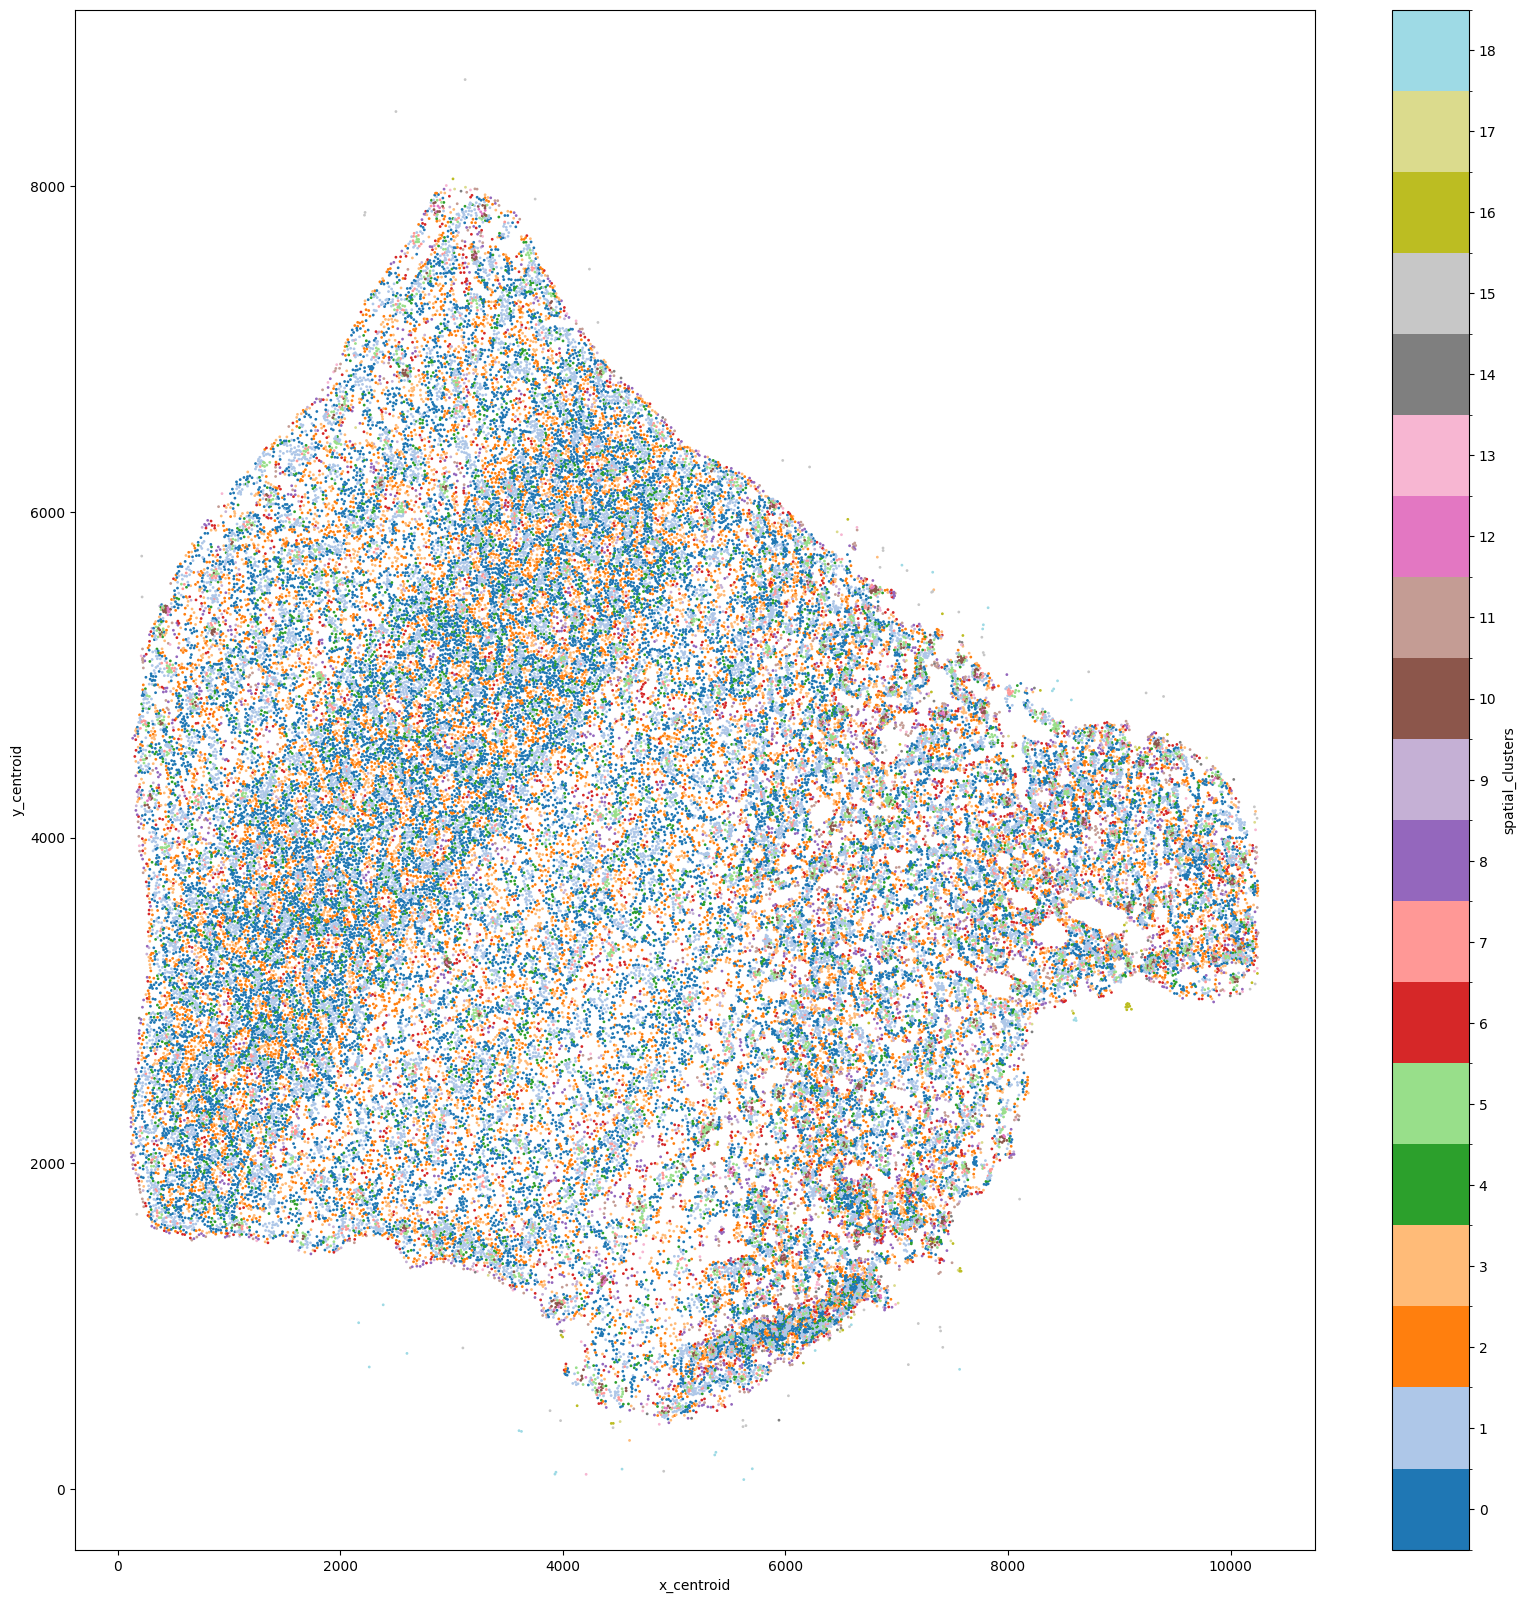

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for post_run_cell), with arguments args (<ExecutionResult object at 79f3a82e75b0, execution_count=23 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79f3a87c8550, raw_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." transformed_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y145sZmlsZQ%3D%3D> result=<Axes: xlabel='x_centroid', ylabel='y_centroid'>>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [23]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
adata.obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="spatial_clusters",
    cmap="tab20",
    s=1,
    ax=ax
)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79f3a4c7ccd0, raw_cell="# sc.pp.neighbors(adata, use_rep="X_node")
# sc.tl.." transformed_cell="# sc.pp.neighbors(adata, use_rep="X_node")
# sc.tl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y156sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

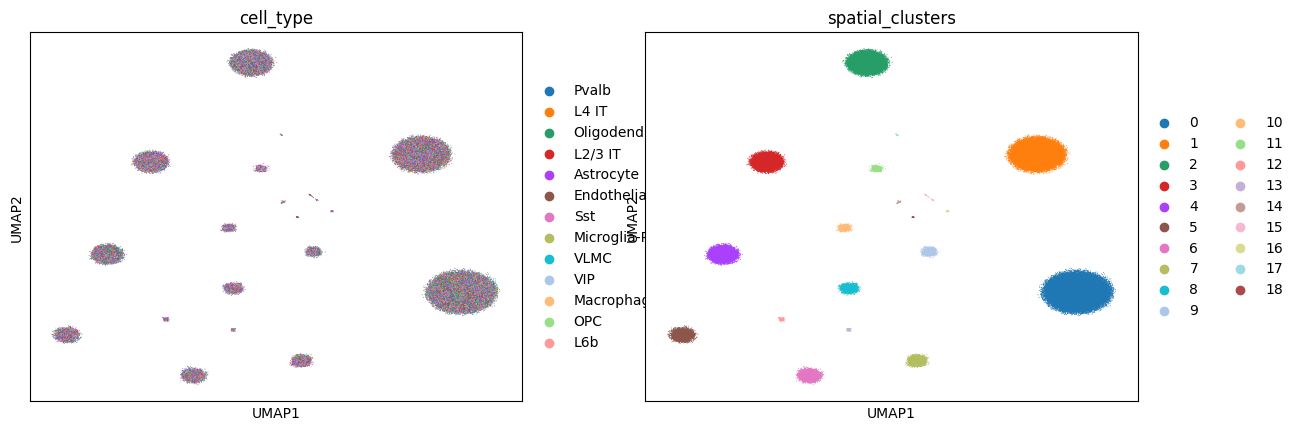

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for post_run_cell), with arguments args (<ExecutionResult object at 79f3a7fcf700, execution_count=24 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79f3a4c7ccd0, raw_cell="# sc.pp.neighbors(adata, use_rep="X_node")
# sc.tl.." transformed_cell="# sc.pp.neighbors(adata, use_rep="X_node")
# sc.tl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y156sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [24]:
# sc.pp.neighbors(adata, use_rep="X_node")
# sc.tl.umap(adata)
# sc.tl.leiden(adata, key_added="leiden", resolution = 0.5)
sc.pl.umap(adata, color=["cell_type", "spatial_clusters"])

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 79f3a62ff250, raw_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." transformed_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y160sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

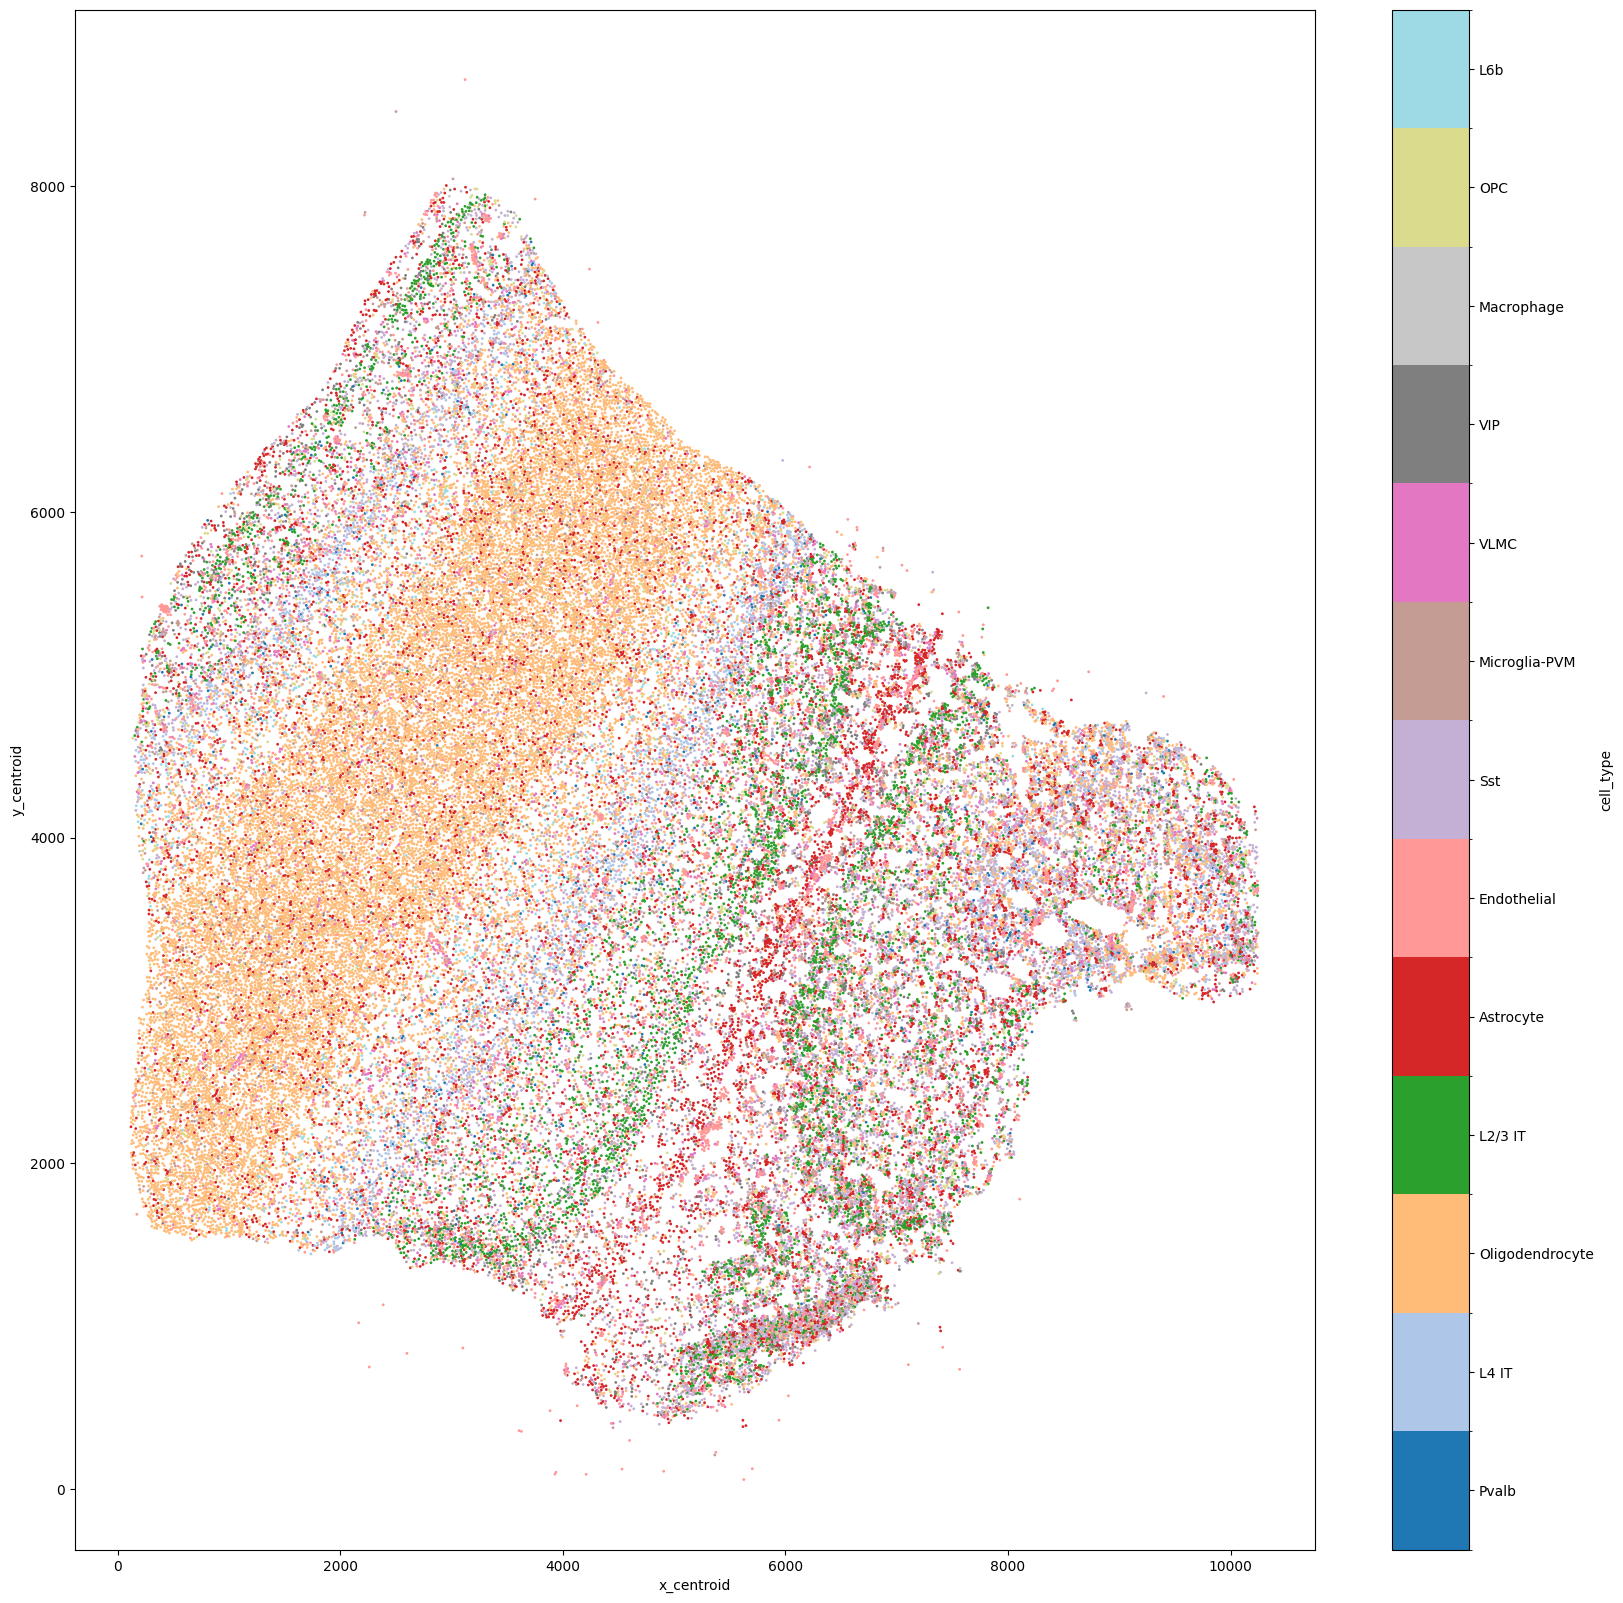

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x79f24104e3c0>> (for post_run_cell), with arguments args (<ExecutionResult object at 79f3a420f460, execution_count=25 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 79f3a62ff250, raw_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." transformed_cell="import matplotlib.pyplot as plt

f, ax = plt.subpl.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/Personal/TokenGT/notebook/data-loading.ipynb#Y160sZmlsZQ%3D%3D> result=<Axes: xlabel='x_centroid', ylabel='y_centroid'>>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [25]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
adata.obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="cell_type",
    cmap="tab20",
    s=1,
    ax=ax
)

In [ ]:
sc.pl.umap(adata, color=["cell_type"])